In [1]:
import numpy as np
from scipy.io import loadmat

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
matplotlib.style.use('seaborn-notebook')
%matplotlib inline

In [2]:
z = loadmat('Exercise Session 2 data_diabete.mat')
t = z['t']
X = z['X']

In [3]:
n, d = X.shape
print(f"{n} observations and {d} features")

442 observations and 10 features


In [4]:
df = pd.DataFrame(np.c_[X, t],
                  columns=('age', 'sex', 'bmi', 'bp',
                           'serum1', 'serum2', 'serum3', 'serum4', 'serum5', 'serum6', 'diabete'))

In [5]:
df.head()

,age,sex,bmi,bp,serum1,serum2,serum3,serum4,serum5,serum6,diabete
0,59.0,2.0,32.1,101.0,157.0,93.2,38.0,4.0,4.8598,87.0,151.0
1,48.0,1.0,21.6,87.0,183.0,103.2,70.0,3.0,3.8918,69.0,75.0
2,72.0,2.0,30.5,93.0,156.0,93.6,41.0,4.0,4.6728,85.0,141.0
3,24.0,1.0,25.3,84.0,198.0,131.4,40.0,5.0,4.8903,89.0,206.0
4,50.0,1.0,23.0,101.0,192.0,125.4,52.0,4.0,4.2905,80.0,135.0


# Visual analysis

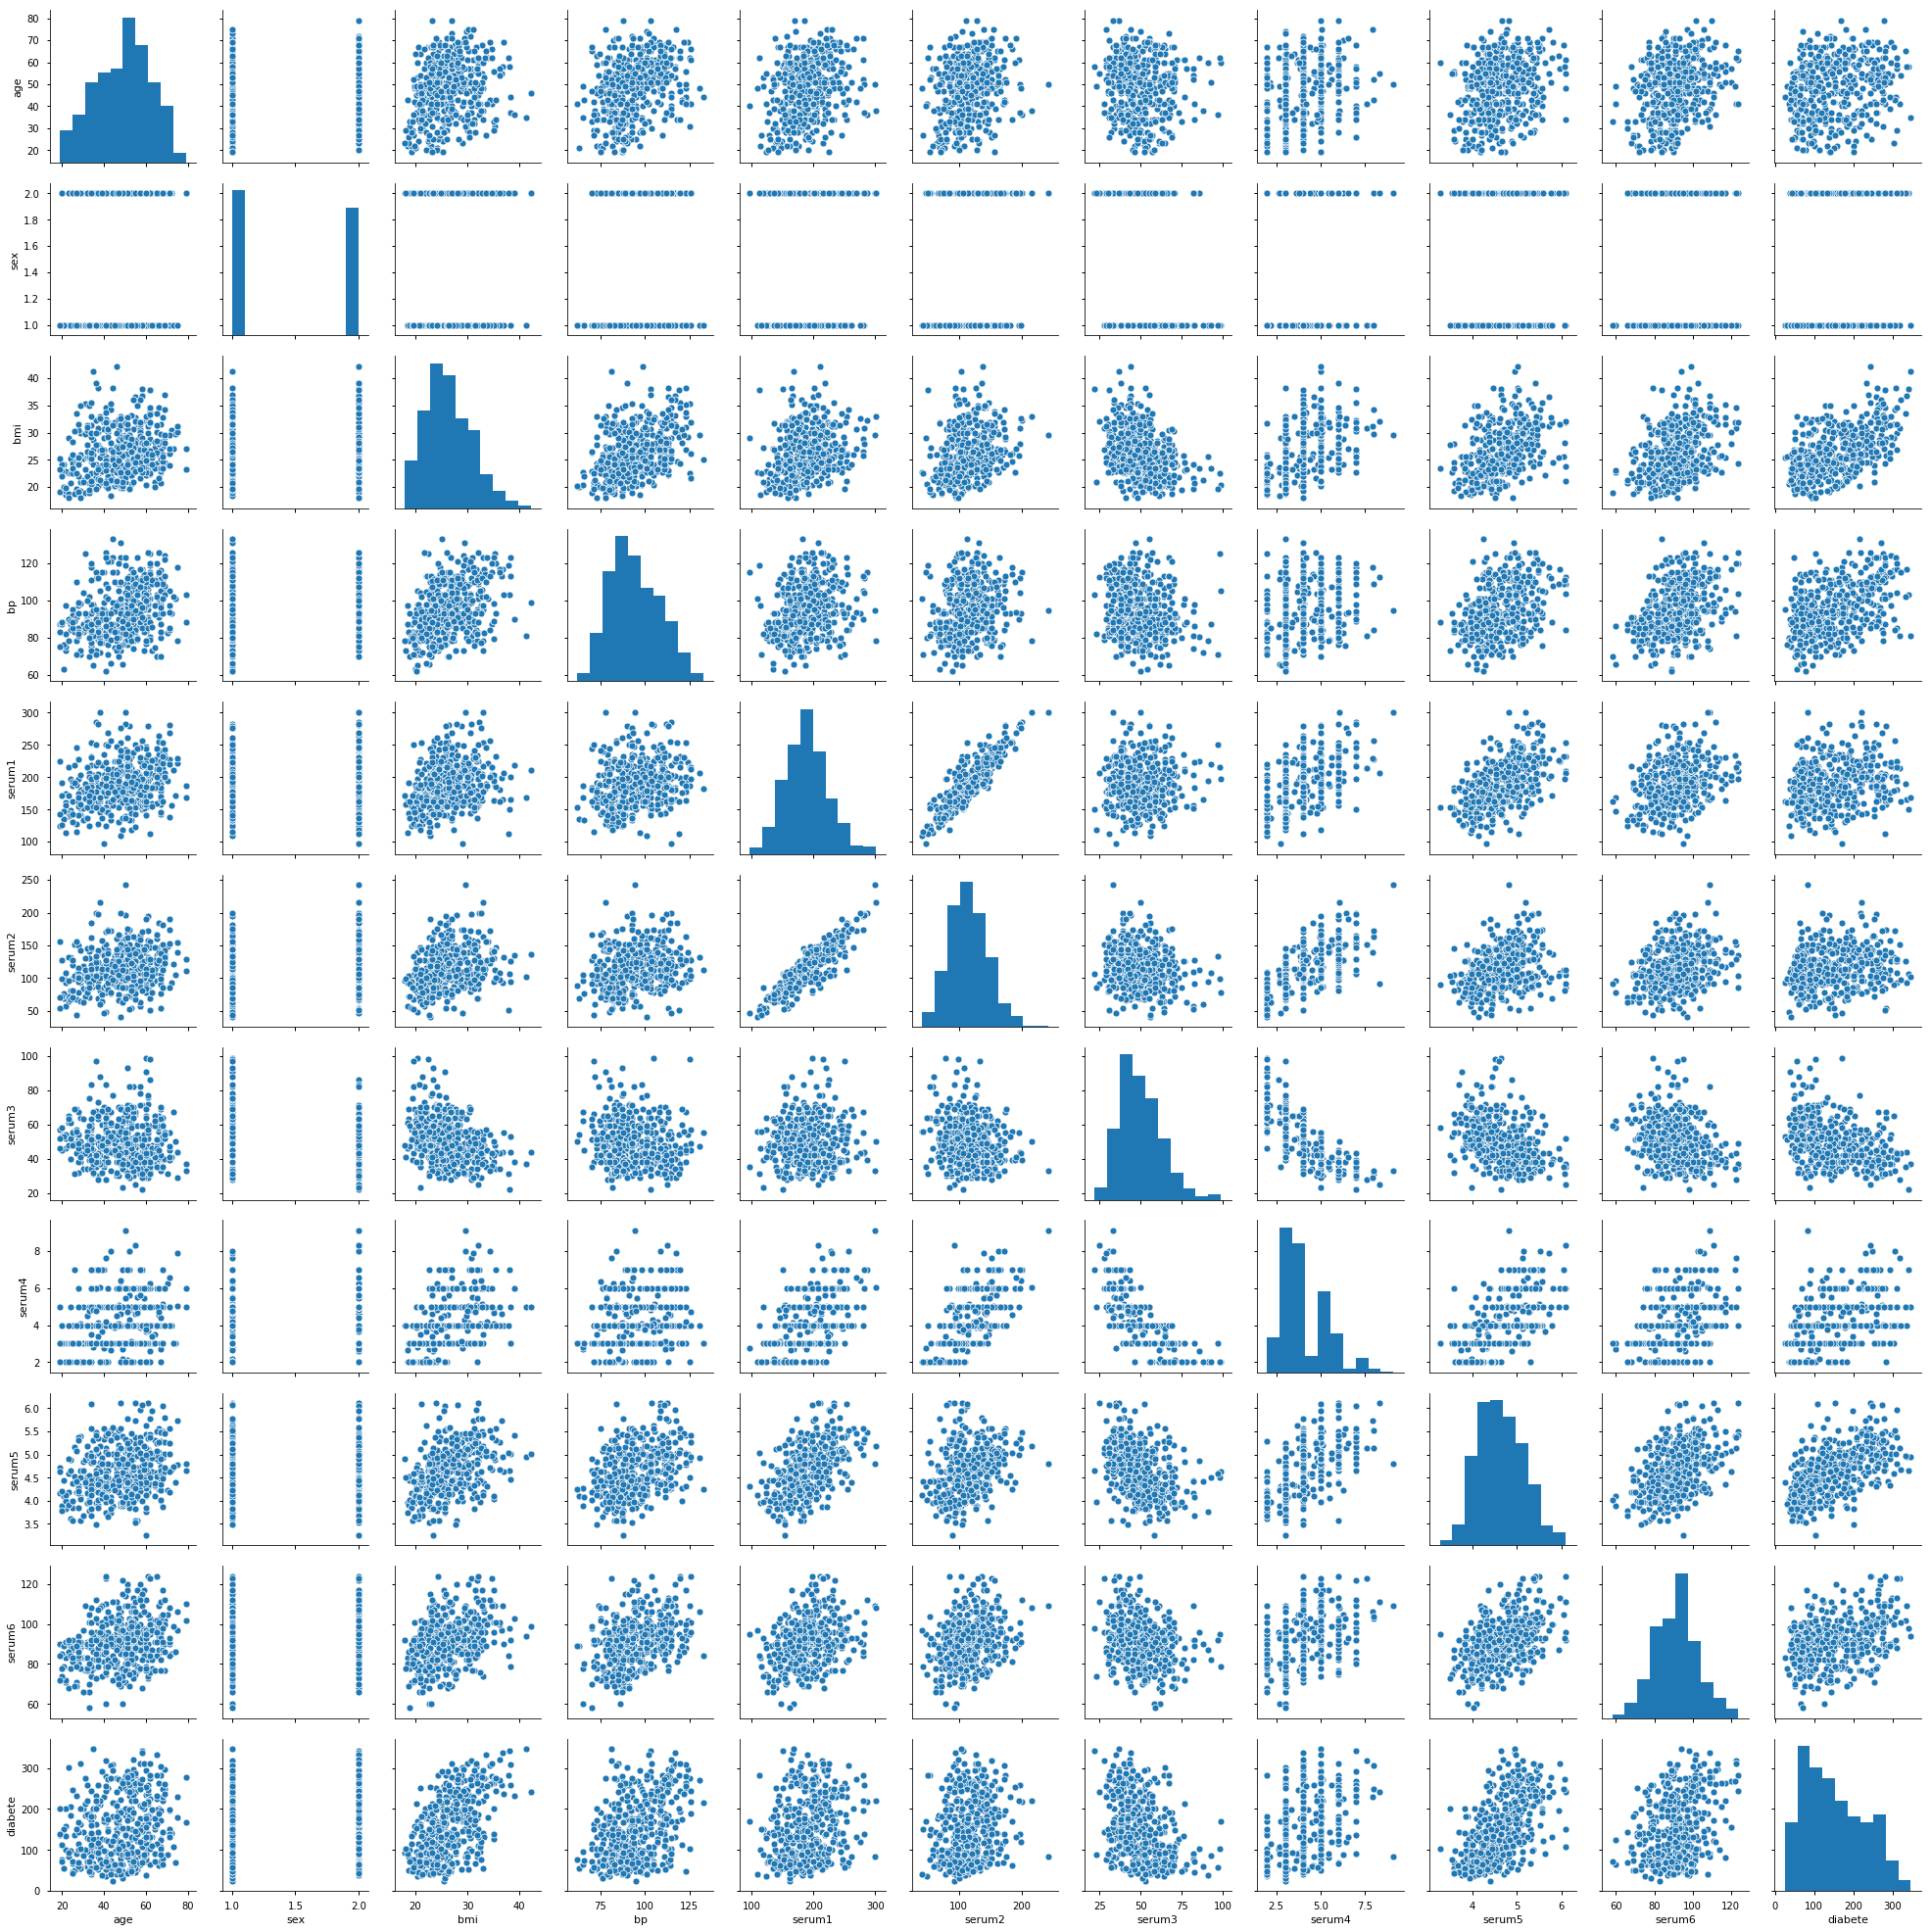

In [6]:
sns.pairplot(df)

In [7]:
mat = df.corr()

mask = np.triu(np.ones(mat.shape)).astype(np.bool)
labels = mat.where(~mask).round(2).replace(np.nan, ' ', regex=True)

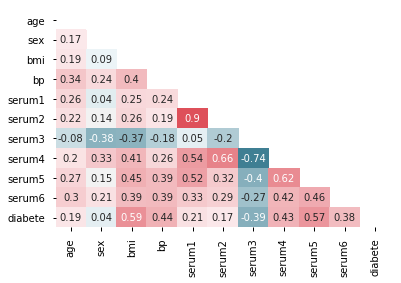

In [8]:
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(mat, cmap=cmap, mask=mask, annot=labels, fmt='', cbar=False)

# Univariate Linear Regression

In [9]:
# Add an intercept/bias in the dataset
df.insert(0, 'intercept', 1)

In [10]:
def pseudo_inverse_regression(X, y):
    return (np.linalg.pinv(X.T @ X) @ X.T) @ y

def mse(X, y, w):
    y_hat = X @ w
    return np.mean((y - y_hat)**2)

In [11]:
X = df[['intercept', 'bmi']].values
y = df.diabete.values.reshape(-1, 1)

# Linear regression for y ~ X
w = pseudo_inverse_regression(X, y)
y_hat = X @ w

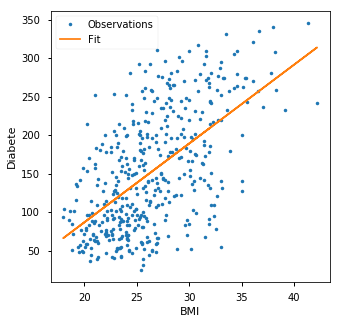

In [12]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.plot(X[:,1], y, '.', label='Observations')
ax.plot(X[:,1], y_hat, '-', label='Fit')
ax.set(xlabel='BMI', ylabel='Diabete')
ax.legend();

# Learning as Training Error Minimisation 

In [13]:
X = df[['intercept', 'bmi']].values
y = df.diabete.values.reshape(-1, 1)

best_w = pseudo_inverse_regression(X, y)
best_mse = mse(X, y, best_w)

In [14]:
best_mse

3890.4565854612724

In [15]:
w_grid = np.mgrid[-400:200:5,0:20:1].reshape(2,-1).T

In [16]:
mse_grid = np.apply_along_axis(lambda w: mse(X, y, w), 1, w_grid)

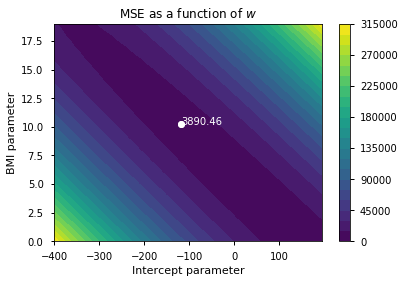

In [17]:
fig, ax = plt.subplots()
cs = ax.contourf(w_grid[:,0].reshape(-1,20), w_grid[:,1].reshape(-1,20), mse_grid.reshape(-1,20), levels=20)
fig.colorbar(cs)

ax.plot((best_w[0],best_w[0]), (best_w[1],best_w[1]), 'wo')
ax.text(best_w[0], best_w[1], best_mse.round(2), color='w')

ax.set(xlabel='Intercept parameter', ylabel='BMI parameter', title='MSE as a function of $w$');

# Bivariate and Multivariate Linear Regression


In [18]:
# diabete ~ 1 + bmi
mse(X, y, best_w)

3890.4565854612724

In [19]:
# diabete ~ 1 + bmi + serum5
X = df[['intercept', 'bmi', 'serum5']].values
w = pseudo_inverse_regression(X, y)
mse(X, y, w)

3205.1900768248533

In [20]:
# diabete ~ 1 + age + sex
X = df[['intercept', 'age', 'bmi']].values
w = pseudo_inverse_regression(X, y)
mse(X, y, w)

3851.799194709598

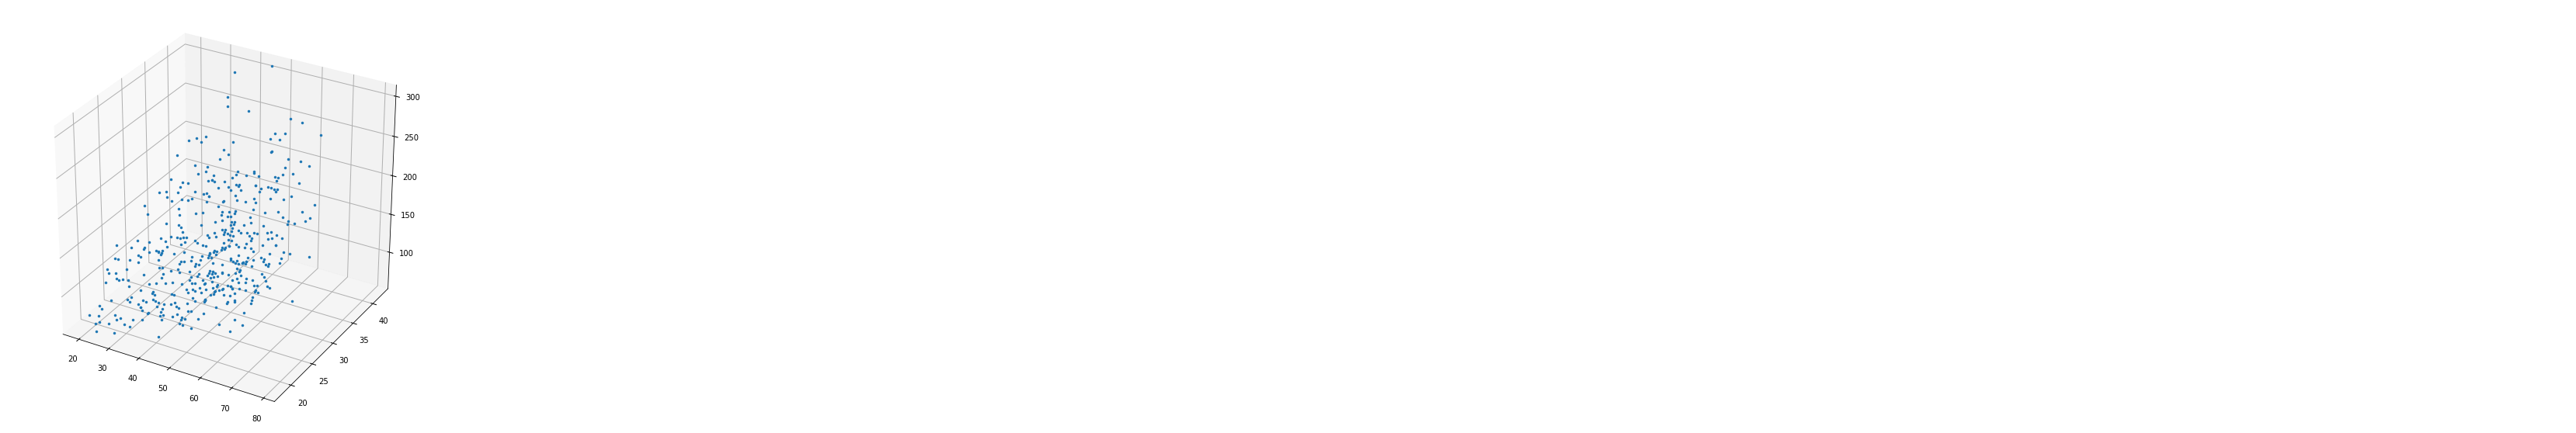

In [21]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,10))
ax = fig.gca(projection='3d')

ax.plot3D(X[:,1], X[:,2], (X @ w)[:,0], '.')

# Principal Component Analysis (PCA)

In [22]:
from scipy.linalg import svd

def pca(X):
    X = X - X.mean(axis=0)
    U, s, Vh = svd(X)

    F = X @ Vh.T
    return F

In [23]:
X = df.drop(['intercept', 'diabete'], axis=1).values
X_pca = pca(X)

In [39]:
# # To verify with scikit-learn:
# from sklearn.decomposition import PCA
# X_pca = PCA().fit(X).transform(X)

In [24]:
# We select the first two features
features_12 = X_pca[:, :2]

# Add intercept
features_12i = np.c_[features_12, np.ones(features_12.shape[0])]

In [25]:
w = pseudo_inverse_regression(features_12i, y)
mse(features_12i, y, w)

4209.094010831374

/Users/cynddl/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


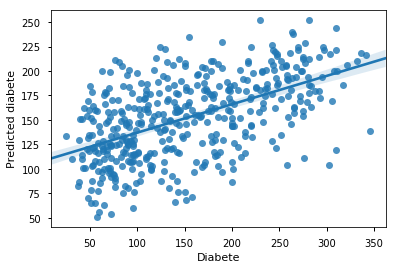

In [26]:
y_hat = (features_12i @ w)[:,0]
sns.regplot(y[:,0], y_hat)
plt.xlabel('Diabete'); plt.ylabel('Predicted diabete');